<a href="https://colab.research.google.com/github/chasubeen/ESAA_8th_OB/blob/Week_16/%ED%8C%8C%EC%9D%B4%EC%8D%AC%20%EB%94%A5%EB%9F%AC%EB%8B%9D%20%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C_4%20-%207.%20%EC%9D%B4%EB%AF%B8%EC%A7%80%20%EB%B6%84%ED%95%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

💚 [개념정리_Notion](https://water-bean.notion.site/4-CNN-931756faaf7f45f2afa4b20d1b799eb7?pvs=4)

# **7-1. 데이터셋 준비**
- 예제 데이터셋: Oxford-IIIT Pet Dataset
- 반려동물의 이미지 및 분류 레이블, 각 이미지를 구성하는 픽셀 단위의 마스크로 구성되어 있음
  - 마스크: 각 픽셀에 대한 범주 레이블
  - 각 픽셀은 다음 세 가지 범주 중 하나에 속함
    - class 1: 반려동물이 속한 픽셀(노란색 영역)
    - class 2: 반려동물과 인접한 픽셀(빨간색 영역)
    - class 3: 위에 속하지 않는 경우/주변 픽셀(파란색 영역)

## **7-1-0. Import**

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow

## **7-1-1.주요 파라미터 설정**

In [2]:
# 이미지 크기
img_w = 128
img_h = 128
img_c = 3
img_shape = (img_w, img_h, img_c)

# 모델 학습
epoch_num = 5
learning_rate = 0.0001
buffer_size = 1000
batch_size = 16

## **7-1-2. 데이터셋**

In [3]:
# 텐서플로 데이터셋 로드

ds_str = 'oxford_iiit_pet'
ds, info = tfds.load(name = ds_str, with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteRKX4JV/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteRKX4JV/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
### 이미지 전처리 함수

def preprocess_image(ds):
    ## 원본 이미지
    img = tf.image.resize(ds['image'], (img_w, img_h))
    img = tf.cast(img, tf.float32) / 255.0

    ## 분할 마스크
    mask = tf.image.resize(ds['segmentation_mask'], (img_w, img_h))
    mask = tf.cast(mask, tf.int32)
    mask = mask - 1 # 0, 1, 2의 정수형 값을 가지도록

    return img, mask

In [5]:
## 데이터 전처리 파이프라인

train_ds = ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


In [6]:
# 샘플 배치 선택

img, mask = next(iter(train_ds))
len(img)

16

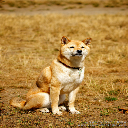

In [7]:
# 샘플 이미지 출력

img = np.array(img[0])*255.0
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)

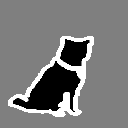

In [8]:
# 샘플 마스크 출력

mask = (np.array(mask[0])/2)*255.0
cv2_imshow(mask)

# **7-2. UNet 모델**

In [9]:
### VGG16 모델(pre-trained)

base_model = tf.keras.applications.VGG16(input_shape = img_shape, include_top = False) # 최종 레이어를 제외하고 불러오기

58889256/58889256 [==============================] - 4s 0us/step


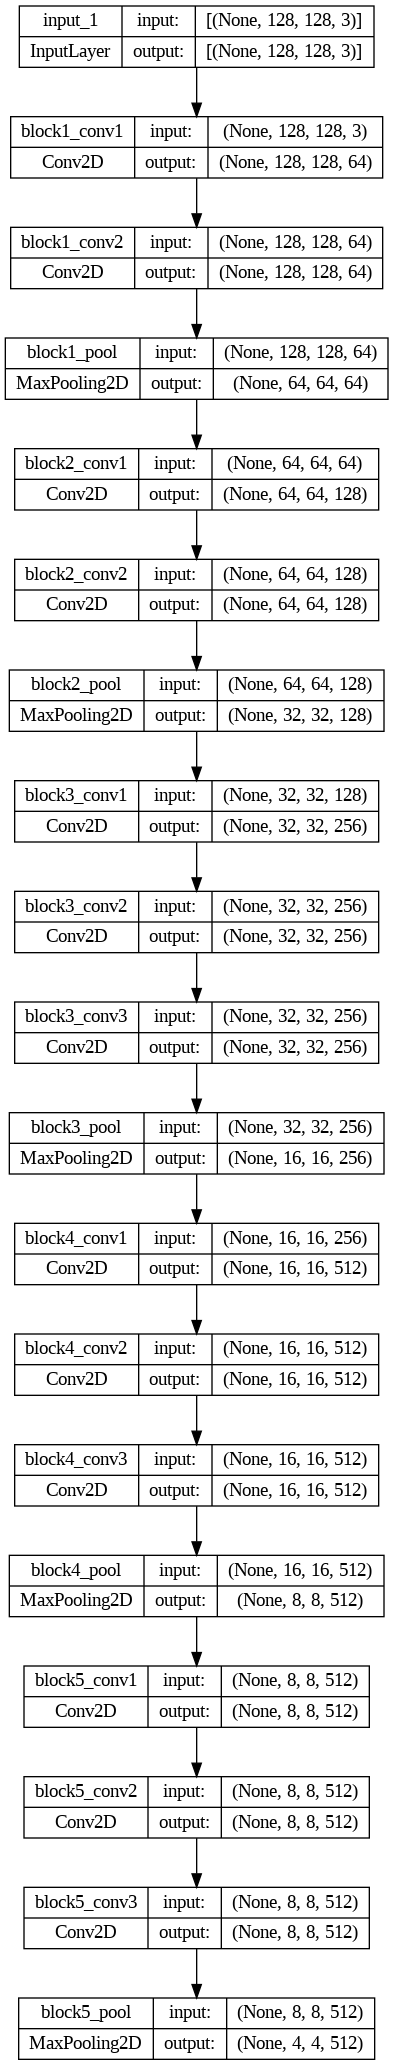

In [10]:
## 모델 구조

tf.keras.utils.plot_model(base_model,show_shapes = True)

## **7-2-1. U-Net 모델 정의**

In [11]:
## VGG16 중간 레이어 출력 텐서를 지정

f_model = tf.keras.Model(inputs = [base_model.input],
                         outputs = [
                             base_model.get_layer(name = 'block5_conv3').output,
                             base_model.get_layer(name = 'block4_conv3').output,
                             base_model.get_layer(name = 'block3_conv3').output,
                             base_model.get_layer(name = 'block2_conv2').output,
                             base_model.get_layer(name = 'block1_conv2').output
])

In [12]:
## 파라미터 고정
# 사전 학습된 파라미터를 인코더에 그대로 사용하기 위함

f_model.trainable = False

In [13]:
### U-Net 구조로 모델 정의
# Encoder 부분에서 5개의 출력을 가져와서 Decoder의 입력으로 전달하며 Upsampling 진행

i = tf.keras.Input(shape = img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64 = f_model(i)

out = tf.keras.layers.Conv2DTranspose(512,3,strides = 2,padding = 'same')(out_8_8_512)
out = tf.keras.layers.Add()([out,out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256,3,strides = 2,padding = 'same')(out)
out = tf.keras.layers.Add()([out,out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128,3,strides = 2,padding = 'same')(out)
out = tf.keras.layers.Add()([out,out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64,3,strides = 2,padding = 'same')(out)
out = tf.keras.layers.Add()([out,out_128_128_64])

out = tf.keras.layers.Conv2D(3, 3, activation = 'relu', padding = 'same') (out)
out = tf.keras.layers.Dense(3,activation = 'softmax')(out)

unet_model = tf.keras.Model(inputs = [i], outputs = [out])

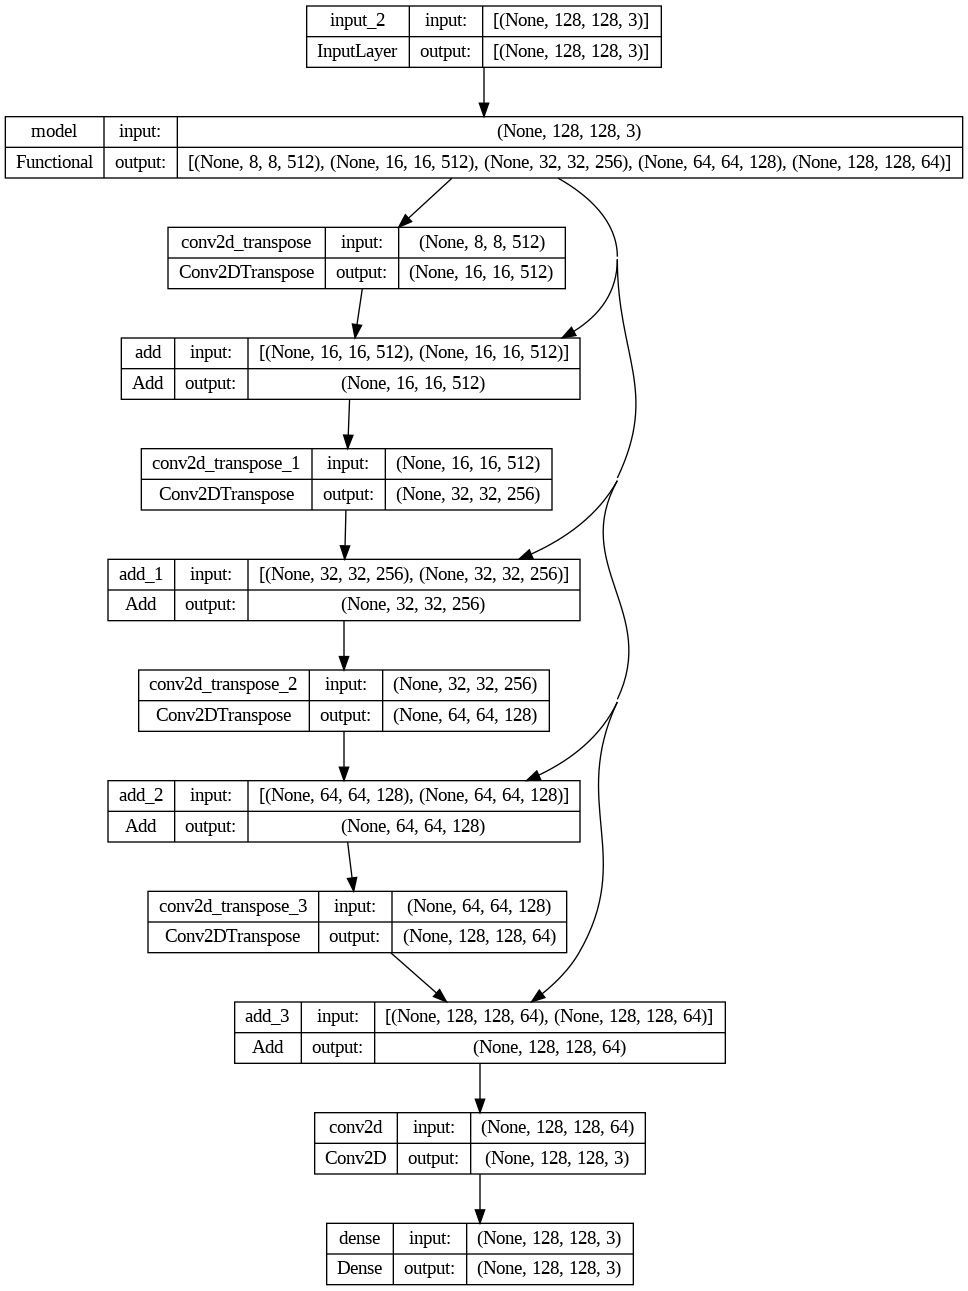

In [14]:
# 모델 구조 시각화

tf.keras.utils.plot_model(unet_model,show_shapes=True)

In [15]:
### 모델 요약
# 인코더 출력에 사용하기 위해 f_model로부터 유래하는 5개 레이어의 14714688개의 파라미터는 학습되지 않도록 고정되어 있음

unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 8, 8, 512),          1471468   ['input_2[0][0]']             
                              (None, 16, 16, 512),        8                                       
                              (None, 32, 32, 256),                                                
                              (None, 64, 64, 128),                                                
                              (None, 128, 128, 64)]                                               
                                                                                            

In [16]:
# 모델 컴파일 및 훈련

loss_f = tf.losses.SparseCategoricalCrossentropy() # 예측 클래스 개수가 3개인 다중 분류 문제
opt = tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer = opt, loss = loss_f, metrics = ['accuracy'])
unet_model.fit(train_ds, batch_size = batch_size, epochs = epoch_num)

Epoch 1/5
230/230 [==============================] - 32s 82ms/step - loss: 0.9315 - accuracy: 0.6207
Epoch 2/5
230/230 [==============================] - 21s 81ms/step - loss: 0.5360 - accuracy: 0.7855
Epoch 3/5
230/230 [==============================] - 21s 79ms/step - loss: 0.4861 - accuracy: 0.8055
Epoch 4/5
230/230 [==============================] - 21s 81ms/step - loss: 0.4659 - accuracy: 0.8118
Epoch 5/5
230/230 [==============================] - 22s 80ms/step - loss: 0.4494 - accuracy: 0.8198


## **7-2-2. 추론**
검증 데이터셋을 모델에 입력하여 이미지 분할 예측

1/1 [==============================] - 0s 308ms/step


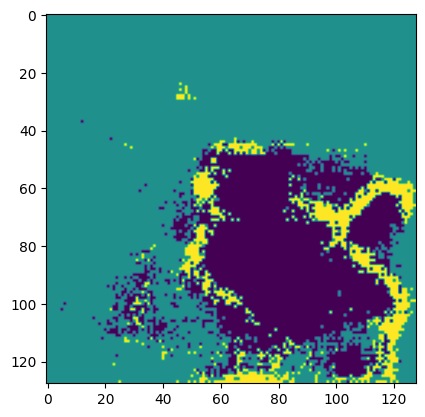

In [17]:
# 1개 배치(16개 이미지)를 선택
img, mask = next(iter(test_ds))

# 모델 예측
pred = unet_model.predict(img)

# 첫번째 이미지 분할 결과를 출력
pred_img = np.argmax(pred[0], -1)
plt.imshow(pred_img)

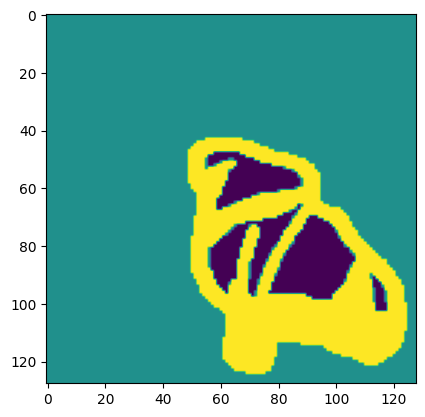

In [18]:
# 첫번째 이미지의 정답 마스크 출력

plt.imshow(np.reshape(mask[0], (128,128)))

어느 정도 객체의 경계를 찾아내는 것을 확인할 수 있다.